# All Imports 

In [1]:
import os
import matplotlib.pyplot as plt
import pathlib
import shutil
import PIL
import tensorflow as tf
import numpy as np
from pathlib import Path
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.initializers import HeNormal

from sklearn.metrics import accuracy_score

from sklearn.metrics import confusion_matrix
import seaborn as sns

# Data Acquisition

Download dataset one from https://www.kaggle.com/datasets/misrakahmed/vegetable-image-dataset
Call this folder 'data'.


Download dataset two https://www.kaggle.com/datasets/kritikseth/fruit-and-vegetable-image-recognition
Call this folder 'data2'.

A new folder of 'final_data' should appear as the combined data, once steps are completed

In [2]:
# The function changes name of vegetables folders within a folder so that the naming matches for dataset 1 and 2
# for example: 'Soy_Beans' gets changed to 'soy beans'

def change_folder_names(file_path): 
    test = []
    for root,dirs,files in os.walk(file_path):
        for dir_name in dirs:
            os.rename(os.path.join(root, dir_name), os.path.join(root, dir_name.lower().replace("_", "")))

In [3]:
# Take the train/test/validate folders within dataset 1 and dataset 2
# change the vegetable folder names within each of these specific folders by changing to lower case.

train_path_1 = Path("./data/train")
validation_path_1 = Path("./data/validation")
test_path_1 = Path("./data/test")

train_path_2 = Path("./data2/train")
validation_path_2 = Path("./data2/validation")
test_path_2 = Path("./data2/test")

train_path = Path("./final_data/train")
validation_path = Path("./final_data/validation")
test_path = Path("./final_data/test")

f_path = Path('./final_data')

change_folder_names(train_path_1)
change_folder_names(validation_path_1)
change_folder_names(test_path_1)
change_folder_names(train_path_2)
change_folder_names(validation_path_2)
change_folder_names(test_path_2)

In [4]:
def proc_img(filepath):

    labels = [str(filepath[i]).split("/")[-2] for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

In [5]:
# First Dataset
train_filepaths_1 = list(train_path_1.glob(r'**/*.jpg'))
train_df_1 = proc_img(train_filepaths_1)

test_filepaths_1 = list(test_path_1.glob(r'**/*.jpg'))
test_df_1 = proc_img(test_filepaths_1)

val_filepaths_1 = list(validation_path_1.glob(r'**/*.jpg'))
val_df_1 = proc_img(val_filepaths_1)


# Second Dataset
train_filepaths_2 = list(train_path_2.glob(r'**/*.jpg'))
train_df_2 = proc_img(train_filepaths_2)

test_filepaths_2 = list(test_path_2.glob(r'**/*.jpg'))
test_df_2 = proc_img(test_filepaths_2)

val_filepaths_2 = list(validation_path_2.glob(r'**/*.jpg'))
val_df_2 = proc_img(val_filepaths_2)


#Combination
train_df = train_df_1.append(train_df_2, ignore_index=True)
test_df = test_df_1.append(test_df_2, ignore_index=True)
val_df = val_df_1.append(val_df_2, ignore_index=True)

In [6]:
print('-- Training set Combo --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

print('-- Training set 1 --\n')
print(f'Number of pictures: {train_df_1.shape[0]}\n')
print(f'Number of different labels: {len(train_df_1.Label.unique())}\n')
print(f'Labels: {train_df_1.Label.unique()}')

print('-- Training set 2 --\n')
print(f'Number of pictures: {train_df_2.shape[0]}\n')
print(f'Number of different labels: {len(train_df_2.Label.unique())}\n')
print(f'Labels: {train_df_2.Label.unique()}')

-- Training set Combo --

Number of pictures: 30000

Number of different labels: 15

Labels: ['cabbage' 'carrot' 'cucumber' 'bittergourd' 'broccoli' 'capsicum'
 'radish' 'tomato' 'papaya' 'brinjal' 'bean' 'potato' 'bottlegourd'
 'cauliflower' 'pumpkin']
-- Training set 1 --

Number of pictures: 15000

Number of different labels: 15

Labels: ['cabbage' 'carrot' 'cucumber' 'bittergourd' 'broccoli' 'capsicum'
 'radish' 'tomato' 'papaya' 'brinjal' 'bean' 'potato' 'bottlegourd'
 'cauliflower' 'pumpkin']
-- Training set 2 --

Number of pictures: 15000

Number of different labels: 15

Labels: ['capsicum' 'cucumber' 'tomato' 'broccoli' 'carrot' 'cauliflower'
 'bittergourd' 'bean' 'bottlegourd' 'brinjal' 'papaya' 'potato' 'pumpkin'
 'radish' 'cabbage']


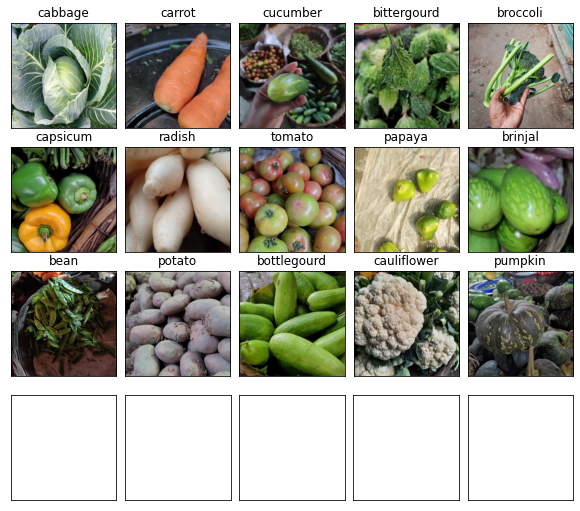

In [52]:
# Create a DataFrame with one Label of each category
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(8, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    if i == 15:
        break
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

# Generate Datasets

At this point data is in a 2d array with col1 = filepath and col2 = label

In [8]:
batch_size=32
epochs=1

In [9]:
# The ImageDataGenerator is an easy way to load and augment images 
#in batches for image classification tasks

train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [10]:
#flow_from_dataframe allows you to input a Pandas dataframe which contains the filenames
#(with or without the extensions) column and a column which has the class names and 
#directly read the images from the directory with their respective class names mapped.


# Create train / test / validate for Combined Dataset

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

Found 30000 validated image filenames belonging to 15 classes.
Found 6000 validated image filenames belonging to 15 classes.
Found 6000 validated image filenames belonging to 15 classes.


In [11]:
# Create train / test / validate for dataset 1

train_images_1 = train_generator.flow_from_dataframe(
    dataframe=train_df_1,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_images_1 = train_generator.flow_from_dataframe(
    dataframe=val_df_1,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_images_1 = test_generator.flow_from_dataframe(
    dataframe=test_df_1,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

Found 15000 validated image filenames belonging to 15 classes.
Found 3000 validated image filenames belonging to 15 classes.
Found 3000 validated image filenames belonging to 15 classes.


In [12]:
# Create train / test / validate for dataset 2

train_images_2 = train_generator.flow_from_dataframe(
    dataframe=train_df_2,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_images_2 = train_generator.flow_from_dataframe(
    dataframe=val_df_2,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_images_2 = test_generator.flow_from_dataframe(
    dataframe=test_df_2,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

Found 15000 validated image filenames belonging to 15 classes.
Found 3000 validated image filenames belonging to 15 classes.
Found 3000 validated image filenames belonging to 15 classes.


# Compiling and Fitting Our Model

In [13]:
# Define/create our model. 

# 1st Conv2D layer: 6 filters, 5x5
# 2nd Conv2D layer: 16 filters, 5x5

# Train model with combined dataset 

model = Sequential()
model.add(Conv2D(6, (5,5), activation='relu', kernel_initializer=HeNormal(), input_shape=(224,224,3,)))
model.add(MaxPool2D())
model.add(Conv2D(16, (5,5), activation='relu', kernel_initializer=HeNormal()))
model.add(Flatten())
model.add(Dense(len(train_df.Label.unique()), activation='softmax'))


model.compile(optimizer='adam',
          loss='categorical_crossentropy',
          metrics=['accuracy'])


history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = batch_size,
    epochs=epochs,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)


pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]
y_test = [labels[k] for k in test_images.classes]

938/938 [==============================] - 1028s 1s/step - loss: 1.1657 - accuracy: 0.7789 - val_loss: 0.6488 - val_accuracy: 0.8187


In [16]:
# Define/create our model again 
# Train model with first dataset


model_1 = Sequential()
model_1.add(Conv2D(6, (5,5), activation='relu', kernel_initializer=HeNormal(), input_shape=(224,224,3,)))
model_1.add(MaxPool2D())
model_1.add(Conv2D(16, (5,5), activation='relu', kernel_initializer=HeNormal()))
model_1.add(Flatten())
model_1.add(Dense(len(train_df_1.Label.unique()), activation='softmax'))


model_1.compile(optimizer='adam',
          loss='categorical_crossentropy',
          metrics=['accuracy'])


history_1 = model_1.fit(
    train_images_1,
    validation_data=val_images_1,
    batch_size = batch_size,
    epochs=epochs,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)


pred_1 = model_1.predict(test_images_1)
pred_1 = np.argmax(pred_1,axis=1)
labels_1 = (train_images_1.class_indices)
labels_1 = dict((v,k) for k,v in labels_1.items())
pred_1 = [labels_1[k] for k in pred_1]
y_test_1 = [labels_1[k] for k in test_images_1.classes]

469/469 [==============================] - 487s 1s/step - loss: 1.7378 - accuracy: 0.6379 - val_loss: 0.6346 - val_accuracy: 0.8073


In [17]:
# Define/create our model again 
# Train model with the second dataset

model_2 = Sequential()
model_2.add(Conv2D(6, (5,5), activation='relu', kernel_initializer=HeNormal(), input_shape=(224,224,3,)))
model_2.add(MaxPool2D())
model_2.add(Conv2D(16, (5,5), activation='relu', kernel_initializer=HeNormal()))
model_2.add(Flatten())
model_2.add(Dense(len(train_df_2.Label.unique()), activation='softmax'))


model_2.compile(optimizer='adam',
          loss='categorical_crossentropy',
          metrics=['accuracy'])


history_2 = model_2.fit(
    train_images_2,
    validation_data=val_images_2,
    batch_size = batch_size,
    epochs=epochs,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)


pred_2 = model_2.predict(test_images_2)
pred_2 = np.argmax(pred_2,axis=1)
labels_2 = (train_images_2.class_indices)
labels_2 = dict((v,k) for k,v in labels_2.items())
pred_2 = [labels_2[k] for k in pred_2]
y_test_2 = [labels_2[k] for k in test_images_2.classes]

469/469 [==============================] - 489s 1s/step - loss: 1.3956 - accuracy: 0.6733 - val_loss: 0.5888 - val_accuracy: 0.8080


# Compiling and Fitting Pretrained Model

In [38]:
# Define/create a pretrained model from kaggle 
# train model with combined dataset

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False
inputs = pretrained_model.input
x = layers.Dense(128, activation='relu')(pretrained_model.output)
x = layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense((15), activation='softmax')(x)
p_model = tf.keras.Model(inputs=inputs, outputs=outputs)


p_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


p_history = p_model.fit(
    train_images,
    validation_data=val_images,
    batch_size = batch_size,
    epochs=epochs,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)


p_pred = p_model.predict(test_images)
p_pred = np.argmax(p_pred,axis=1)
p_labels = (train_images.class_indices)
p_labels = dict((v,k) for k,v in p_labels.items())
p_pred = [p_labels[k] for k in p_pred]

py_test = [p_labels[k] for k in test_images.classes]

938/938 [==============================] - 1157s 1s/step - loss: 0.0597 - accuracy: 0.9849 - val_loss: 0.0060 - val_accuracy: 0.9983


In [35]:
# Define/create a pretrained model from kaggle 
# train model with the first dataset

pretrained_model_1 = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model_1.trainable = False
inputs_1 = pretrained_model_1.input
x_1 = layers.Dense(128, activation='relu')(pretrained_model_1.output)
x_1 = layers.Dense(128, activation='relu')(x_1)
outputs_1 = tf.keras.layers.Dense((len(train_df_1.Label.unique())), activation='softmax')(x_1)
p_model_1 = tf.keras.Model(inputs=inputs_1, outputs=outputs_1)


p_model_1.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


p_history = p_model_1.fit(
    train_images_1,
    validation_data=val_images_1,
    batch_size = batch_size,
    epochs=epochs,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)


p_pred_1 = p_model_1.predict(test_images_1)
p_pred_1 = np.argmax(p_pred_1,axis=1)
p_labels_1 = (train_images_1.class_indices)
p_labels_1 = dict((v,k) for k,v in p_labels_1.items())
p_pred_1 = [p_labels_1[k] for k in p_pred_1]
py_test_1 = [p_labels_1[k] for k in test_images_1.classes]

469/469 [==============================] - 596s 1s/step - loss: 0.1118 - accuracy: 0.9725 - val_loss: 0.0173 - val_accuracy: 0.9953


In [36]:
# Define/create a pretrained model from kaggle 
# train model with the second dataset

pretrained_model_2 = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model_2.trainable = False
inputs_2 = pretrained_model_2.input
x_2 = layers.Dense(128, activation='relu')(pretrained_model_2.output)
x_2 = layers.Dense(128, activation='relu')(x_2)
outputs_2 = tf.keras.layers.Dense((len(train_df_2.Label.unique())), activation='softmax')(x_2)
p_model_2 = tf.keras.Model(inputs=inputs_2, outputs=outputs_2)


p_model_2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


p_history = p_model_2.fit(
    train_images_2,
    validation_data=val_images_2,
    batch_size = batch_size,
    epochs=epochs,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)


p_pred_2 = p_model_2.predict(test_images_2)
p_pred_2 = np.argmax(p_pred_2,axis=1)
p_labels_2 = (train_images_2.class_indices)
p_labels_2 = dict((v,k) for k,v in p_labels_2.items())
p_pred_2 = [p_labels_2[k] for k in p_pred_2]
py_test_2 = [p_labels_2[k] for k in test_images_2.classes]

469/469 [==============================] - 578s 1s/step - loss: 0.1119 - accuracy: 0.9709 - val_loss: 0.0200 - val_accuracy: 0.9950


# Results

In [30]:
# Print/display a classifcation report of our model predicting all 3 datasets

acc = accuracy_score(y_test, pred)
acc_1 = accuracy_score(y_test_1, pred_1)
acc_2 = accuracy_score(y_test_2, pred_2)


from sklearn.metrics import classification_report, confusion_matrix


print(f'Our accuracy on the combo data test set: {100*acc:.2f}%')
print(classification_report(y_test, pred))
print(f'Our accuracy on the data 1 test set: {100*acc_1:.2f}%')
print(classification_report(y_test_1, pred_1))

print(f'Our accuracy on the data 2 test set: {100*acc_2:.2f}%')
print(classification_report(y_test_2, pred_2))



Our accuracy on the combo data test set: 82.27%
              precision    recall  f1-score   support

        bean       0.80      0.67      0.73       400
 bittergourd       0.93      0.82      0.87       400
 bottlegourd       0.93      0.80      0.86       400
     brinjal       0.67      0.83      0.74       400
    broccoli       0.68      0.89      0.77       400
     cabbage       0.68      0.82      0.74       400
    capsicum       0.90      0.92      0.91       400
      carrot       0.91      0.97      0.94       400
 cauliflower       0.76      0.78      0.77       400
    cucumber       0.81      0.80      0.81       400
      papaya       0.89      0.97      0.93       400
      potato       0.95      0.78      0.86       400
     pumpkin       0.91      0.74      0.82       400
      radish       0.96      0.82      0.89       400
      tomato       0.75      0.74      0.74       400

    accuracy                           0.82      6000
   macro avg       0.84      0.8

In [41]:
# Print/display a classifcation report of the pre-trained model predicting all 3 datasets

p_acc = accuracy_score(py_test, p_pred)
p_acc_1 = accuracy_score(py_test_1, p_pred_1)
p_acc_2 = accuracy_score(py_test_2, p_pred_2)



print(f'Pretrained accuracy on the combo data test set: {100*p_acc:.2f}%')
print(classification_report(py_test, p_pred))
print(f'Pretrained accuracy on the data 1 test set: {100*p_acc_1:.2f}%')
print(classification_report(py_test_1, p_pred_1))
print(f'Pretrained accuracy on the data 2 test set: {100*p_acc_2:.2f}%')
print(classification_report(py_test_2, p_pred_2))

Pretrained accuracy on the combo data test set: 99.80%
              precision    recall  f1-score   support

        bean       0.99      1.00      1.00       400
 bittergourd       1.00      0.99      0.99       400
 bottlegourd       1.00      1.00      1.00       400
     brinjal       1.00      1.00      1.00       400
    broccoli       0.99      1.00      1.00       400
     cabbage       1.00      1.00      1.00       400
    capsicum       1.00      1.00      1.00       400
      carrot       1.00      1.00      1.00       400
 cauliflower       1.00      0.99      1.00       400
    cucumber       1.00      0.99      0.99       400
      papaya       1.00      1.00      1.00       400
      potato       1.00      1.00      1.00       400
     pumpkin       1.00      1.00      1.00       400
      radish       1.00      1.00      1.00       400
      tomato       1.00      0.99      1.00       400

    accuracy                           1.00      6000
   macro avg       1.00  

# Our Combined Confusion Matrix

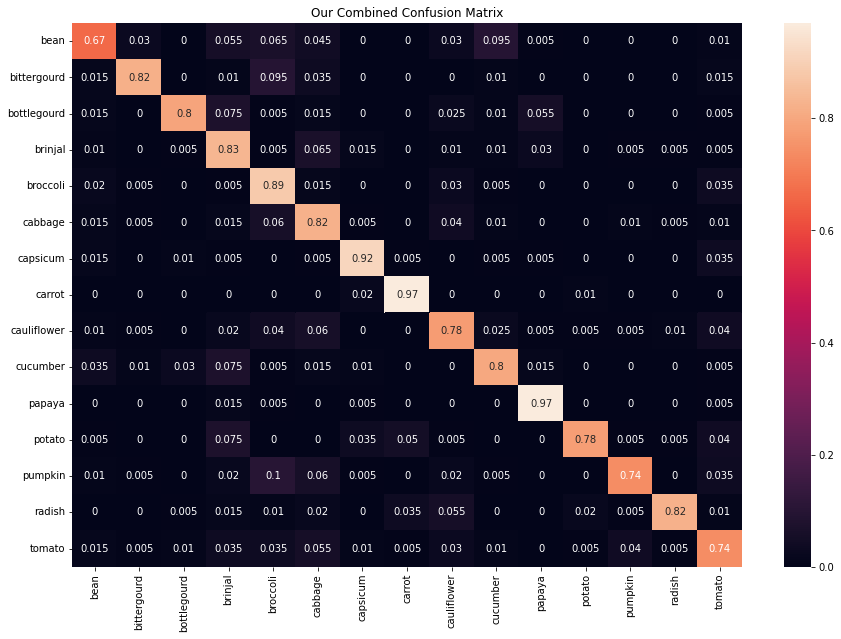

In [42]:
# Print a confusion matrix of the combined dataset using our model

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(y_test)), 
            yticklabels = sorted(set(y_test)),
            )
plt.title('Our Combined Confusion Matrix')
plt.show()

# Our D1 Confusion Matrix

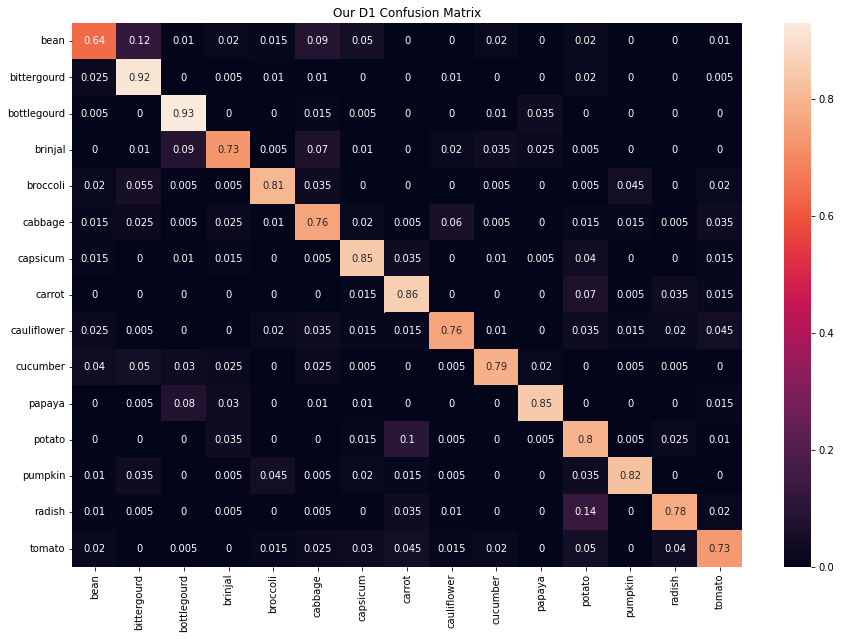

In [43]:
# Print a confusion matrix of the first dataset using our model

cf_matrix_1 = confusion_matrix(y_test_1, pred_1, normalize='true')
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix_1, 
            annot=True, 
            xticklabels = sorted(set(y_test_1)), 
            yticklabels = sorted(set(y_test_1)),
            )
plt.title('Our D1 Confusion Matrix')
plt.show()

# Our D2 Confusion Matrix

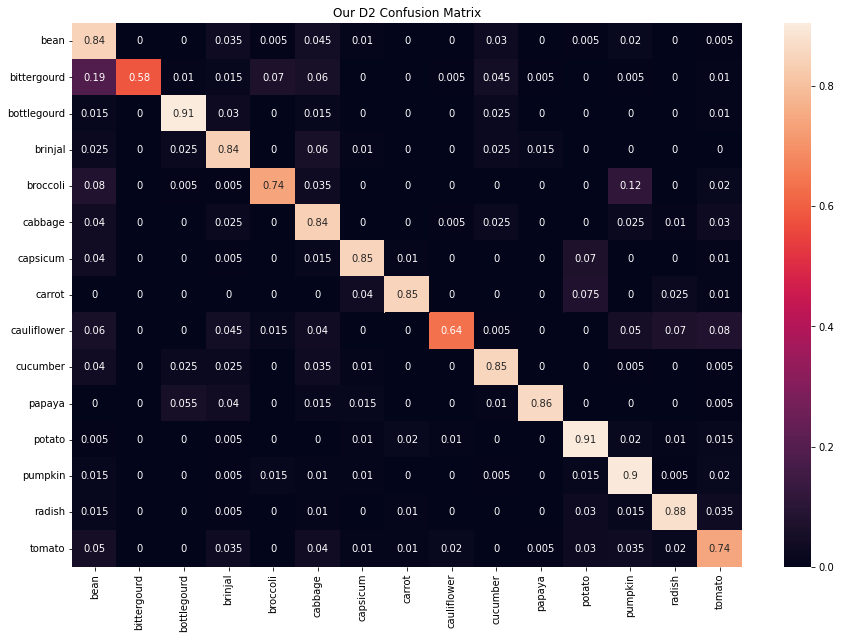

In [44]:
# Print a confusion matrix of the second dataset using our model

cf_matrix_2 = confusion_matrix(y_test_2, pred_2, normalize='true')
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix_2, 
            annot=True, 
            xticklabels = sorted(set(y_test_2)), 
            yticklabels = sorted(set(y_test_2)),
            )
plt.title('Our D2 Confusion Matrix')
plt.show()

# Pretrained Confusion Matrix

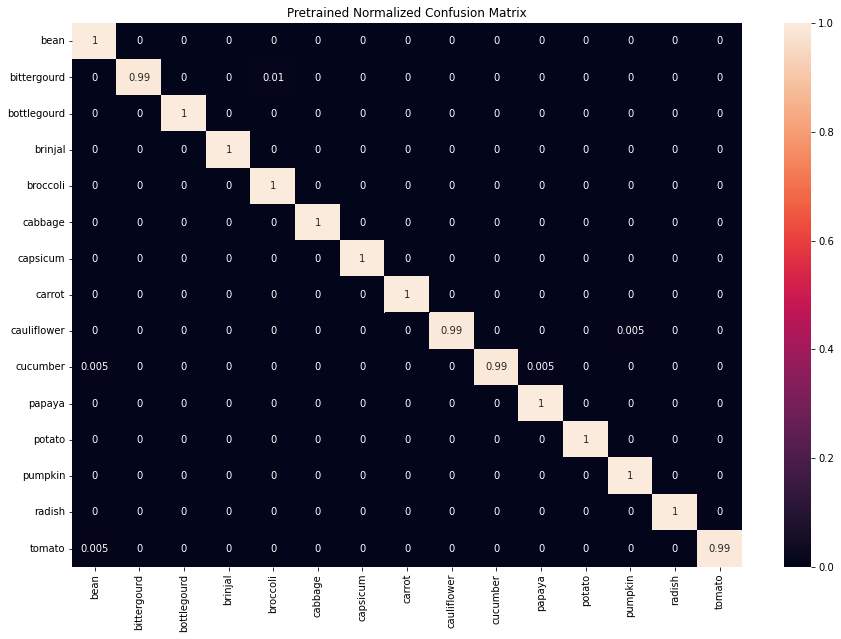

In [45]:
# Print a confusion matrix of the combined dataset using the pre-trained model

cf_matrix = confusion_matrix(py_test, p_pred, normalize='true')
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(py_test)), 
            yticklabels = sorted(set(py_test)),
            )
plt.title('Pretrained Normalized Confusion Matrix')
plt.show()

# Pretrained D1 Confusion Matrix

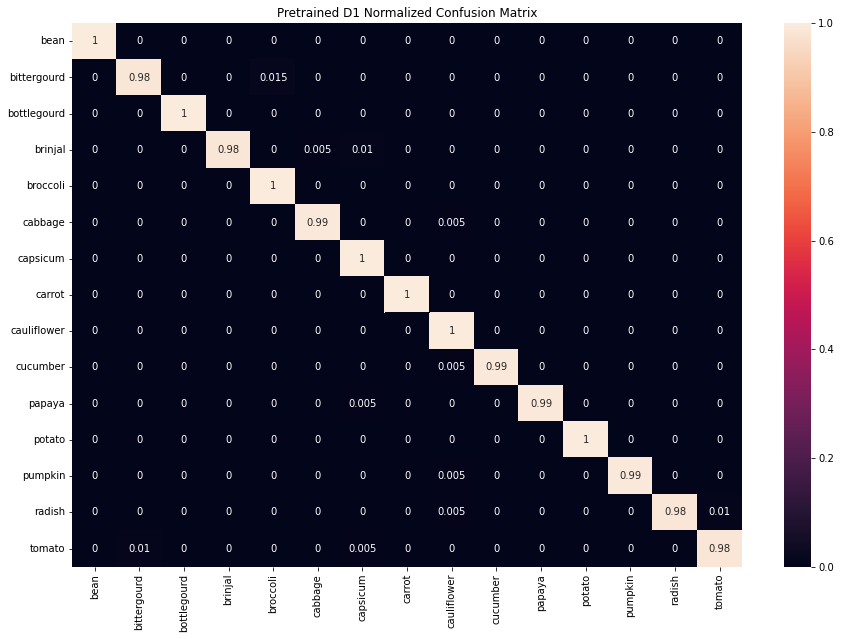

In [46]:
# Print a confusion matrix of the first dataset using the pre-trained model

cf_matrix_1 = confusion_matrix(py_test_1, p_pred_1, normalize='true')
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix_1, 
            annot=True, 
            xticklabels = sorted(set(py_test_1)), 
            yticklabels = sorted(set(py_test_1)),
            )
plt.title('Pretrained D1 Normalized Confusion Matrix')
plt.show()

# Pretrained D2 Confusion Matrix

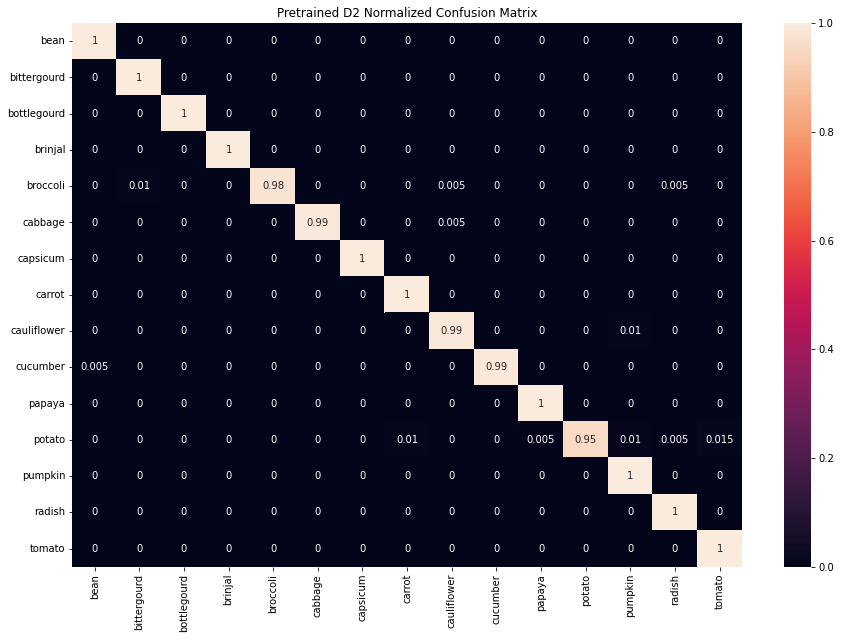

In [47]:
# Print a confusion matrix of the second dataset using the pre-trained model

cf_matrix_2 = confusion_matrix(py_test_2, p_pred_2, normalize='true')
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix_2, 
            annot=True, 
            xticklabels = sorted(set(py_test_2)), 
            yticklabels = sorted(set(py_test_2)),
            )
plt.title('Pretrained D2 Normalized Confusion Matrix')
plt.show()